# Credit Risk Modeling

## Importing libraries

In [7]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier #Decision Tree algorithm
from sklearn.model_selection import train_test_split #Data split function
from sklearn.preprocessing import LabelEncoder #OneHotEncoding
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

import pydotplus
from IPython.display import Image

## Importing data

In [8]:
data = pd.read_csv('credit.csv')
data.head()

,OBS#,CHK_ACCT,DURATION,HISTORY,NEW_CAR,USED_CAR,FURNITURE,RADIOTV,EDUCATION,RETRAINING,...,AGE,OTHER_INSTALL,RENT,OWN_RES,NUM_CREDITS,JOB,NUM_DEPENDENTS,TELEPHONE,FOREIGN,RESPONSE
0,1,0,6,4,0,0,0,1,0,0,...,67,0,0,1,2,2,1,1,0,1
1,2,1,48,2,0,0,0,1,0,0,...,22,0,0,1,1,2,1,0,0,0
2,3,3,12,4,0,0,0,0,1,0,...,49,0,0,1,1,1,2,0,0,1
3,4,0,42,2,0,0,1,0,0,0,...,45,0,0,0,1,2,2,0,0,1
4,5,0,24,3,1,0,0,0,0,0,...,53,0,0,0,2,2,2,0,0,0


## Data exploration

In [9]:
print(data.shape)

(1000, 32)


In [10]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   OBS#              1000 non-null   int64
 1   CHK_ACCT          1000 non-null   int64
 2   DURATION          1000 non-null   int64
 3   HISTORY           1000 non-null   int64
 4   NEW_CAR           1000 non-null   int64
 5   USED_CAR          1000 non-null   int64
 6   FURNITURE         1000 non-null   int64
 7   RADIOTV           1000 non-null   int64
 8   EDUCATION         1000 non-null   int64
 9   RETRAINING        1000 non-null   int64
 10  AMOUNT            1000 non-null   int64
 11  SAV_ACCT          1000 non-null   int64
 12  EMPLOYMENT        1000 non-null   int64
 13  INSTALL_RATE      1000 non-null   int64
 14  MALE_DIV          1000 non-null   int64
 15  MALE_SINGLE       1000 non-null   int64
 16  MALE_MAR_or_WID   1000 non-null   int64
 17  COAPPLICANT       1000 non-null   

These are the columns in the dataset we're working with. It includes information such as purpose of credit, checking account balance, employment status and so on.  

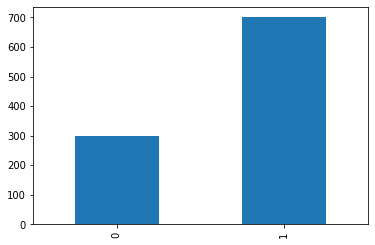

In [11]:
ax = data['RESPONSE'].value_counts().plot(kind='bar')

Roughly 30% of the credit applications were approved in this set. 

## Visualizing the Data

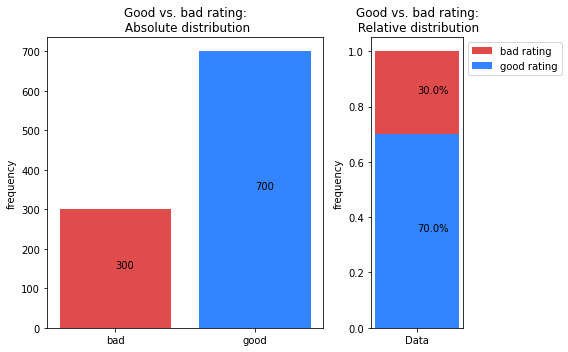

In [12]:
keys, counts = np.unique(data.RESPONSE, return_counts="0")
counts_norm = counts/counts.sum()

#print(keys)
#print(counts)
#print(counts_norm)

fig = plt.figure(figsize=(8, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3,1])

ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['bad', 'good'], counts, color=['#d91e1e','#0066ff'], alpha=0.8)
ax0 = plt.title('Good vs. bad rating:\n Absolute distribution') 
ax0 = plt.ylabel('frequency')
ax0 = plt.text(['bad'], counts[0]/2, counts[0])
ax0 = plt.text(['good'], counts[1]/2, counts[1]) 

ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['Data'], [counts_norm[0]], label='bad rating', bottom=counts_norm[1], color='#d91e1e', alpha=0.8)
ax1 = plt.bar(['Data'], [counts_norm[1]], label='good rating', color='#0066ff', alpha=0.8)
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('Good vs. bad rating:\n Relative distribution')
ax1 = plt.ylabel('frequency')
ax1 = plt.text(['Data'],counts_norm[1]/2, '{}%'.format((counts_norm[1]*100).round(1)))
ax1 = plt.text(['Data'],(counts_norm[0]/2)+counts_norm[1], '{}%'.format((counts_norm[0]*100).round(1)))

plt.tight_layout()
plt.show()

Same information as above, but in a more presentable format, thanks to the matplotlib.pyplot package. 

## Preprocessing the Data

In [13]:
data = data.drop(['OBS#'], axis=1)

Dropping the column labeled OBS, as it does not seem to serve any purpose and thus adding noise to our data. 

In [14]:
data = pd.get_dummies(data, columns=["CHK_ACCT", "HISTORY", "SAV_ACCT", "EMPLOYMENT", "PRESENT_RESIDENT", "JOB"], prefix=["CHK_ACCT", "HISTORY", "SAV_ACCT", "EMPLOYMENT", "PRESENT_RESIDENT", "JOB"])

Changing these variables in these columns into dummy variables (0/1) to ensure compatibility with the machine learning library.

## Splitting the data

Next, we're splitting the data into two, the training set and the tests set. The training set is the data we feed to the model, and the test set is used to confirm whether the model actually works. The visualization shows us that the train/test sets roughly follow the dataset average when it comes to the proportion of good and bad credit applications. 

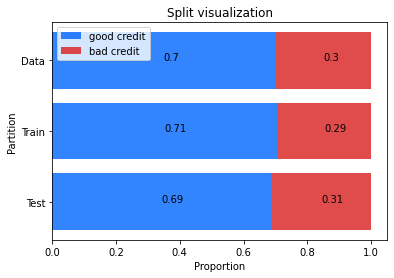

In [58]:
X, y = data.loc[:, data.columns != 'RESPONSE'], data['RESPONSE'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234) 

train_dist = y_train.value_counts() / len(y_train)
test_dist = y_test.value_counts() / len(y_test)
data_dist = data['RESPONSE'].value_counts() / len(data)

fig, ax = plt.subplots()

ax.barh(['Test','Train','Data'], [test_dist[1], train_dist[1], data_dist[1]], color='#0066ff', alpha=0.8, label='good credit')
ax.barh(['Test','Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], left=[test_dist[1], train_dist[1], data_dist[1]], color='#d91e1e', alpha=0.8, label='bad credit')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['Test', 'Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], [test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2+b, part, str(np.round(a, 2)))
    plt.text(b/2, part, str(np.round(b, 2)));

## Building an (unbalanced) Decision Tree model

Over two-thirds of the entries in our dataset refer to approved credit applications. This means that it's *skewed*, meaning that we have less data about rejected applications. This is not ideal as we would like to have a model with similar prediction power detecting good applications versus bad applications. However, let's see where we end up with an unbalanced model first.

The next cell is where our decision tree model is built, while the following cell generates us the image using which we're able to observe the logic of the model. This is useful since usually the logic of ML models is hidden inside a 'black box', meaning that it is difficult to grasp the logic behind the decisions of the model.   

In [59]:
clf = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=3)

clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)
y_pred_probs = clf.predict_proba(X_test)

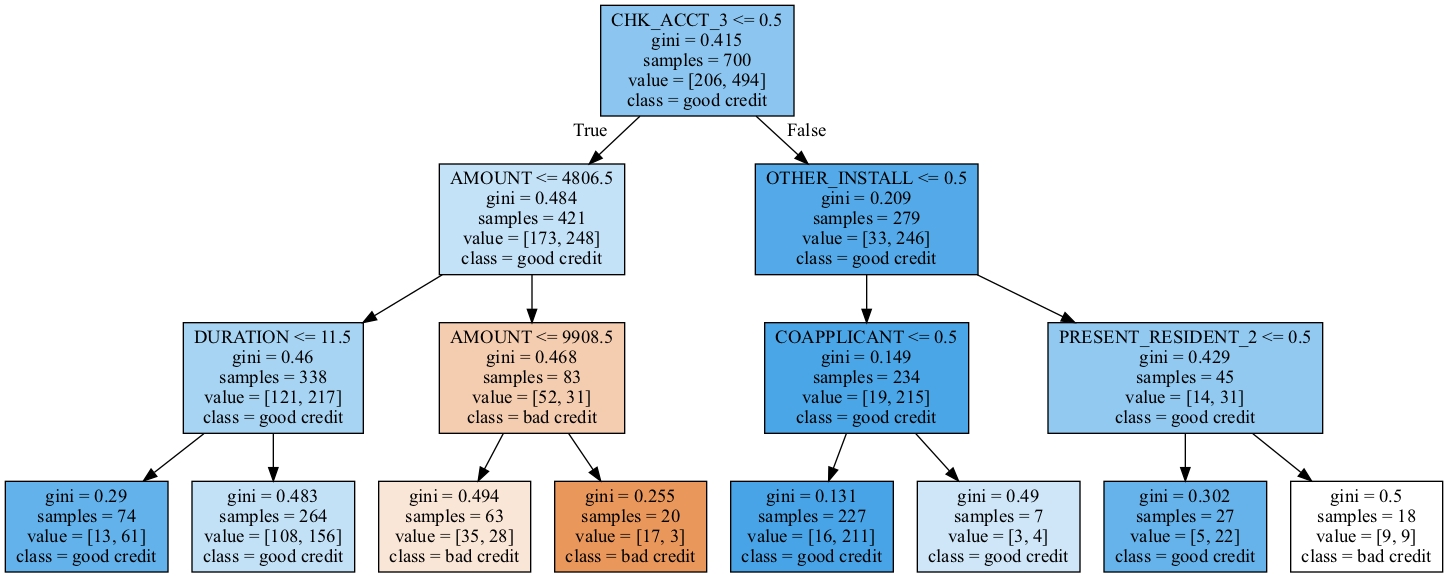

In [60]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X_train.columns, 
                                class_names=['bad credit', 'good credit'], filled=True) #or use y_train.unique()

graph = pydotplus.graph_from_dot_data(dot_data)  

Image(graph.create_png())

The decision tree tells us about the criteria using which it makes its predicionts, such as checking account balance, amount of credit applied for, whether there are other outstanding credit installments and so on. 

The goal of the model is to separate good and bad credit applications into as pure nodes as possible. The gini value (between 0 and ½) is an indicator of the pureness of the node, with 0 being 100% pure and 0.5 being a 50/50 split between good and bad applications. 

In [61]:
print ("Accuracy is: ", (accuracy_score(y_test,y_pred)*100).round(2))

Accuracy is:  65.33


Accuracy for the unbalanced model comes down at 65.33%.

## Rebalancing with SMOTE

Previously, we build a model with a dataset in which the split between good and bad applications was 70/30. How could we fix this skew?

Fortunately, there is a solution. 

Introducing the Synthetic Minority Oversampling technique, SMOTE. 

In [62]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(X_train, y_train)

sm_dist = y_sm.value_counts() / len(y_sm)

print(y_sm.value_counts())
print(sm_dist)


0    494
1    494
Name: RESPONSE, dtype: int64
0    0.5
1    0.5
Name: RESPONSE, dtype: float64


## Building a balanced Decision Tree model

What SMOTE does is it injects synthetic data into the set, mimicking the characteristics of the minority class in the original dataset, in this case the minority class being bad credit applications. Let's see what happens.

In [63]:
clf_sm = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=3)

clf_sm.fit(X_sm, y_sm)


y_pred_sm = clf_sm.predict(X_test)
y_pred_probs_sm = clf_sm.predict_proba(X_test)

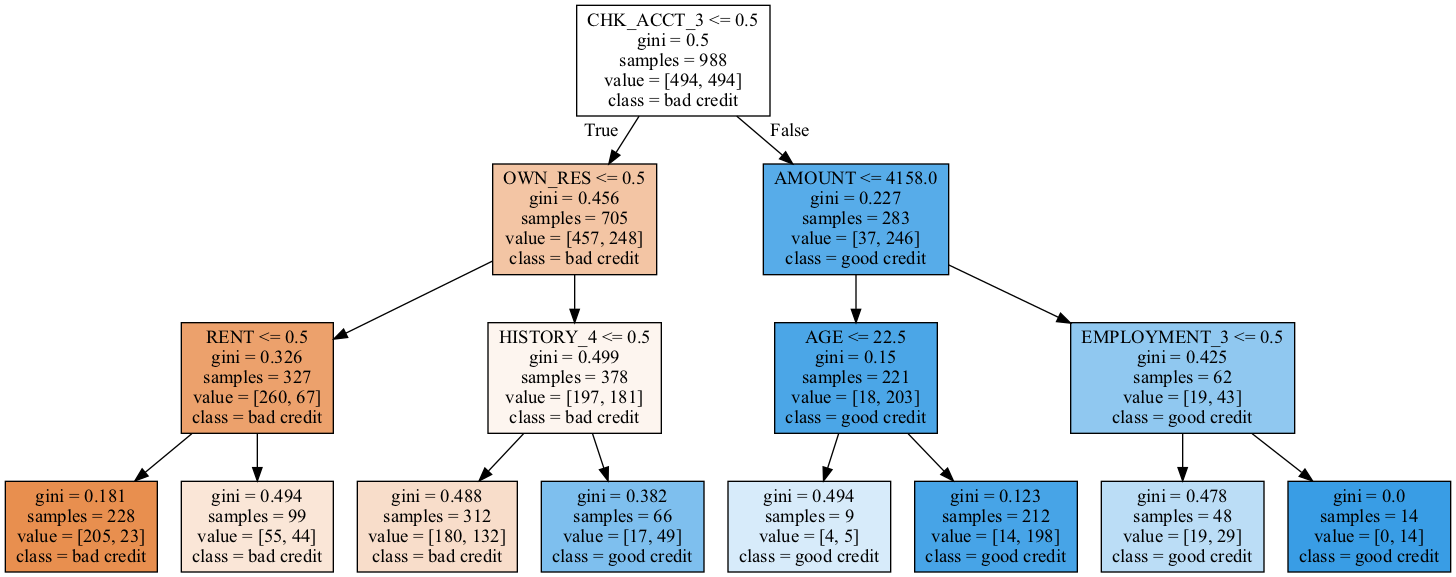

In [64]:
dot_data_sm = tree.export_graphviz(clf_sm, out_file=None, 
                                feature_names=X_train.columns, 
                                class_names=['bad credit', 'good credit'], filled=True) #or use y_train.unique()

graph_sm = pydotplus.graph_from_dot_data(dot_data_sm)  

Image(graph_sm.create_png())

In [66]:
print ("Accuracy is: ", (accuracy_score(y_test,y_pred_sm)*100).round(2))

Accuracy is:  65.67


Accuracy measures within one percentage point compared to the unbalanced model, so there should be no real difference between the two, right? 

Well, let's do some side-by-side comparison of these two models to find out if that is the case. 

## Evaluating the models

### Confusion Matrices, ROC and AUC

First, we'll generate confusion matrices for the models. This visualizes the number of false negatives, true negatives, false positives and true positives for us. 

In [67]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() /2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylim([1.5, -0.5]) #added to fix a bug that causes the matrix to be squished
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

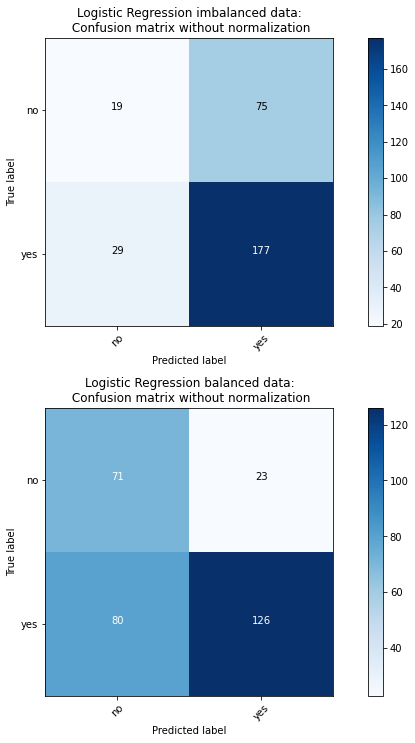

In [68]:
class_names = ['no', 'yes']
cnf_matrix_lr_imb = confusion_matrix(y_test, y_pred)
cnf_matrix_lr_bal = confusion_matrix(y_test, y_pred_sm)

np.set_printoptions(precision=2)

plt.figure(figsize=(20, 15))

#Plot Logistic Regression (imbalanced) confusion matrix
plt.subplot(321) 
plot_confusion_matrix(cnf_matrix_lr_imb, classes=class_names,
                      title='Logistic Regression imbalanced data:\n Confusion matrix without normalization')

#Plot Logistic Regression (balanced) confusion matrix
plt.subplot(323) 
plot_confusion_matrix(cnf_matrix_lr_bal, classes=class_names,
                      title='Logistic Regression balanced data:\n Confusion matrix without normalization')

plt.show()

Even though the models return similar accuracy, their profiles are very different, as we can see from the confusion matrices. Some simple statistics below, rounded to the nearest percentage point:

Unbalanced Model: Precision 70%, Recall 86%, F-Score 77%, Specificity 20%   

Balanced Model: Precision 85%, Recall 61%, F-Score 71%, Specificity 76%

Next, let's calculate the Receiving Operating Characteristics for these models and get the Area Under the Curve figures. (translation: let's figure out the prediction capabilities of the models)

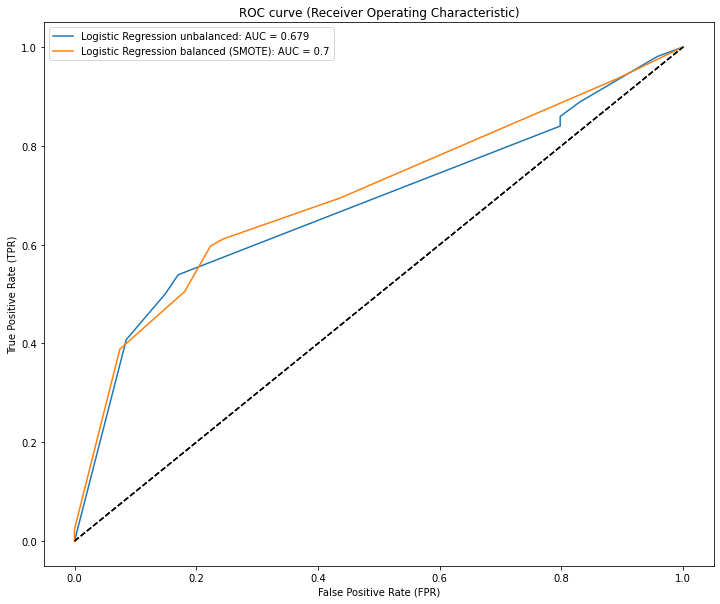

In [71]:
plt.figure(figsize=(12,10))

for test, pred, name in zip([y_test, y_test, y_test],  [y_pred_probs[:,1],y_pred_probs_sm[:,1]], ['Logistic Regression unbalanced','Logistic Regression balanced (SMOTE)']):
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()

The AUC figure roughly represents the prediction power of the model, i.e. the ability to recognize bad applications as bad and good applications as good. 0 means that the inverse of the prediction of the model is always true, while 0.5 would indicate a model that has no prediction power whatsoever. The figures tell us that the balanced  model has a slightly better prediction power at 0.7 compared to the 0.679 of the unbalanced model.

However, the interesting part is in the graph. We can see that they cross, twice. What does this mean? In simple terms, it means that even though the balanced model has a bigger AUC overall, not *always* is it the better choice for production. Let's explore that in the final section.

## Bottom Line: Which Model is Better?

To answer to the question, one needs to know two vital pieces of information:

* the net profit arising from approving a successful credit application
* the net loss caused by approving a bad credit application

The balanced model is a much more conservative in its predictions, meaning that it does not approve credit applications as easily. This can be demonstrated by the discrepancy in the recall, precision and specificity scores of the models. However, if we can hedge our risk with regards to bad credit applciations while pocketing most of the profit from good applications, the unbalanced model might be a better choice. 
